In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision.datasets import DatasetFolder
import torchvision
from tqdm.notebook import tqdm as tqdm
from torchsampler import ImbalancedDatasetSampler
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from torch.utils.data.sampler import SubsetRandomSampler
# from jacobian import JacobianReg

In [2]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.')
else:
    print('CUDA is available!')
device = "cuda" if train_on_gpu else "cpu"

CUDA is available!


In [3]:
train_image_path = "/home/chisc/workspace/wuzhenrong/galaxy/three_final/train/"
val_image_path = "/home/chisc/workspace/wuzhenrong/galaxy/three_final/validation/"
test_image_path = "/home/chisc/workspace/wuzhenrong/galaxy/three_final/test/"

In [4]:
batch_size = 32
# torch.manual_seed(0) # random seed

# transforms.GaussianBlur(7,3)
# transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
# class0 = 212
# class1 = 158
# class2 = 2209
# class_weights = [class0/2209, class1/2209, class2/2209]

# train_set_size = int(len(train_data) * 0.9)
# valid_set_size = len(train_data) - train_set_size
# train_set, val_set = torch.utils.data.random_split(train_data, [train_set_size, valid_set_size])
# print(train_data)

# class0 = 351
# class1 = 265
# class2 = 1839
# class_weights = [class0/2455, class1/2455, class2/2455]
# target = torch.cat((torch.zeros(class0), torch.ones(class1), torch.ones(class2)*2)).long()
# weights = 1. / torch.tensor(class_weights, dtype=torch.float)
# # weights = weights.double()
# # print(weights)
# target = target[torch.randperm(len(target))]# shuffle
# sampler_weights = weights[target]
# class_sampler = WeightedRandomSampler(weights=sampler_weights, num_samples=2000, replacement=True)



# E type :212
# I type :158
# S type :1839
# All :2209
### new
# E type :351
# I type :265
# S type :1839
# All :2455

### latest
# E type :732
# I type :270
# S type :1466
## All :2468
train_trans = transforms.Compose([
#                                   transforms.RandomHorizontalFlip(),
#                                   transforms.RandomRotation((-30, 30)),
#                                   transforms.Resize((255, 255)),
#                                   transforms.CenterCrop(210),
                                  transforms.Resize((255, 255)),
#                                   transforms.GaussianBlur(7,3),
#                                   transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
                                  transforms.ToTensor()])

train_data = ImageFolder(train_image_path, transform = train_trans)
train_loader = DataLoader(train_data, pin_memory = True, batch_size = batch_size, sampler=ImbalancedDatasetSampler(train_data))

val_trans = transforms.Compose([transforms.Resize((255, 255)),transforms.ToTensor()])
val_data = ImageFolder(val_image_path, transform = val_trans)
val_loader = DataLoader(val_data, shuffle = True)

test_trans = transforms.Compose([transforms.Resize((255, 255)),transforms.ToTensor()])
test_data = ImageFolder(test_image_path, transform = test_trans)
test_loader = DataLoader(test_data, shuffle = True)

print('Train:', len(train_data))
print('Valid:', len(val_data))
print('Test:', len(test_data))

Train: 2468
Valid: 100
Test: 100


tensor([0, 2, 1, 0, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 0, 2, 1, 1, 1, 0, 0, 0, 2,
        0, 1, 0, 2, 2, 1, 1, 1])
tensor(0)


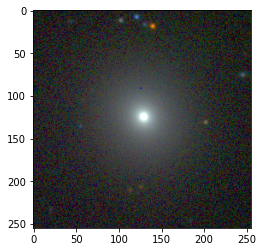

tensor(2)


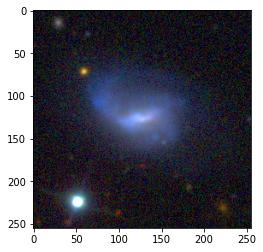

tensor(1)


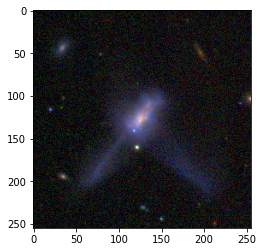

In [5]:
# for i, j in train_loader:
#     break
images, labels = next(iter(train_loader))
print(labels)
for i in np.arange(3):
    print(labels[i])
    plt.figure(i)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.show()

In [6]:
# 1. Input layer
# 2. Convolutional layer
# 3. ReLU layer
# 4. Pooling layer
# 5. Fully-connected layer
class Galaxy(nn.Module):
  def __init__(self):
    super(Galaxy, self).__init__()
    # input_shape = (3, 224, 224)
    # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, 
    #                 padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
    # in_channels: Input channels
    # out_channels: Output channels
    # kernel_size: Fillter size
    # stride: Each step our Fillter move
    # padding: We want our image can remain origin size
    self.cnn = nn.Sequential(
        ## CNN1
        nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 1, padding = 1), # padding = kernel_size / 2
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (64, 112, 112)
        ## CNN2
        nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (128, 56, 56)
        ## CNN3
        nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (256, 28, 28)
        ## CNN4
        nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (512, 14, 14)
        ## CNN5
        nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)## (512, 7, 7)
        ## CNN6
#         nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 3, stride = 1, padding = 1),
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size = 2)## (1024, 3, 3)
    )
    self.fc = nn.Sequential(
        nn.Linear(512 * 7 * 7, 256), # Fully-connected layer
        nn.Dropout(0.5), # Avoid overfitting
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.Dropout(0.5),
        nn.ReLU(),
#         nn.Linear(512, 256),
#         nn.Dropout(0.5),
#         nn.ReLU(),
        nn.Linear(128, 3)
    )
  # forward propagation
  def forward(self, x):
    x = self.cnn(x)
    x = x.flatten(1)
    x = self.fc(x)
    return x

In [7]:
model = Galaxy()
# model = torchvision.models.vgg16(pretrained=False)
# model = torchvision.models.resnet18(pretrained=False)
model = model.to(device)
print(model)

Galaxy(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=25088, out_features=256, bias=Tru

In [8]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0008)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.9, weight_decay=0.01)
loss_func = nn.CrossEntropyLoss()
# # reg = JacobianReg() # Jacobian regularization
# lambda_JR = 0.01 # hyperparameter
l1_crit = nn.L1Loss(size_average=False)
factor = 0.005
n_epochs = 40
train_loss_record = []
train_acc_record = []
val_loss_record = []
val_acc_record = []
min_loss = 2000.
for epoch in range(n_epochs):
    train_loss = 0.0
    val_loss = 0.0
    train_acc = 0.0
    val_acc = 0.0
    model.train()
    for x, y in tqdm(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        prediction = model(x)
        reg_loss = 0
        reg_loss = l1_crit(prediction.argmax(dim = 1), y)
        
        super_loss = loss_func(prediction, y)
        
        loss = super_loss + factor*reg_loss
        
        loss.backward()
        optimizer.step()
        
        acc = ((prediction.argmax(dim = 1) == y).float().mean())
        train_acc += acc/len(train_loader)
        train_loss += loss/len(train_loader)
    print(f"[ Train | {epoch+1}/{n_epochs} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
    train_loss_record.append(train_loss)
    train_acc_record.append(train_acc)

    model.eval()
    for x, y in tqdm(val_loader):
        x, y = x.to(device), y.to(device)
        prediction = model(x)
#         reg_loss = 0

#         reg_loss = l1_crit(prediction.argmax(dim = 1), y)
        
        loss = loss_func(prediction, y)
        
#         loss = super_loss + factor*reg_loss
        
        loss.backward()
        acc = ((prediction.argmax(dim = 1) == y).float().mean())
        val_acc += acc/len(val_loader)
        val_loss += loss/len(val_loader)
        if loss < min_loss:
            min_loss = loss
            torch.save(model, 'E_I_S_new.pkl')
    print(f"[ Validation | {epoch+1}/{n_epochs} ] loss = {val_loss:.5f}, acc = {val_acc:.5f}")
    val_loss_record.append(val_loss)
    val_acc_record.append(val_acc)
# torch.save(model, 'E_I_Sc.pkl')

/home/chisc/.pyenv/versions/torch/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


  0%|          | 0/78 [00:00<?, ?it/s]

/home/chisc/.pyenv/versions/torch/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[ Train | 1/40 ] loss = 1.00009, acc = 0.47075


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 1/40 ] loss = 0.85761, acc = 0.64000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 2/40 ] loss = 0.71660, acc = 0.68229


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 2/40 ] loss = 0.58787, acc = 0.72000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 3/40 ] loss = 0.61632, acc = 0.74279


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 3/40 ] loss = 0.56794, acc = 0.76000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 4/40 ] loss = 0.59536, acc = 0.75521


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 4/40 ] loss = 0.55735, acc = 0.74000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 5/40 ] loss = 0.54385, acc = 0.78325


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 5/40 ] loss = 0.70374, acc = 0.70000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 6/40 ] loss = 0.54951, acc = 0.79046


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 6/40 ] loss = 0.49239, acc = 0.83000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 7/40 ] loss = 0.48517, acc = 0.81731


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 7/40 ] loss = 0.41330, acc = 0.85000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 8/40 ] loss = 0.44445, acc = 0.82853


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 8/40 ] loss = 0.42862, acc = 0.83000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 9/40 ] loss = 0.46474, acc = 0.84375


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 9/40 ] loss = 0.46272, acc = 0.86000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 10/40 ] loss = 0.39163, acc = 0.87059


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 10/40 ] loss = 0.52260, acc = 0.82000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 11/40 ] loss = 0.35809, acc = 0.87420


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 11/40 ] loss = 0.59783, acc = 0.83000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 12/40 ] loss = 0.37394, acc = 0.87300


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 12/40 ] loss = 0.44713, acc = 0.86000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 13/40 ] loss = 0.34952, acc = 0.88021


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 13/40 ] loss = 0.60272, acc = 0.80000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 14/40 ] loss = 0.36139, acc = 0.87340


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 14/40 ] loss = 0.56747, acc = 0.83000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 15/40 ] loss = 0.34737, acc = 0.88341


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 15/40 ] loss = 0.57894, acc = 0.83000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 16/40 ] loss = 0.35433, acc = 0.87981


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 16/40 ] loss = 0.52773, acc = 0.82000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 17/40 ] loss = 0.32615, acc = 0.88502


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 17/40 ] loss = 0.43948, acc = 0.82000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 18/40 ] loss = 0.32248, acc = 0.89063


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 18/40 ] loss = 0.49665, acc = 0.83000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 19/40 ] loss = 0.30175, acc = 0.89623


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 19/40 ] loss = 0.41539, acc = 0.84000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 20/40 ] loss = 0.31746, acc = 0.89183


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 20/40 ] loss = 0.67287, acc = 0.83000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 21/40 ] loss = 0.28122, acc = 0.90064


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 21/40 ] loss = 0.52323, acc = 0.84000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 22/40 ] loss = 0.27173, acc = 0.90104


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 22/40 ] loss = 0.64063, acc = 0.84000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 23/40 ] loss = 0.27674, acc = 0.90505


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 23/40 ] loss = 0.42656, acc = 0.84000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 24/40 ] loss = 0.25213, acc = 0.91026


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 24/40 ] loss = 0.57198, acc = 0.81000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 25/40 ] loss = 0.24894, acc = 0.91546


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 25/40 ] loss = 0.59314, acc = 0.82000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 26/40 ] loss = 0.26974, acc = 0.91066


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 26/40 ] loss = 0.51281, acc = 0.83000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 27/40 ] loss = 0.22881, acc = 0.92909


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 27/40 ] loss = 0.75986, acc = 0.80000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 28/40 ] loss = 0.26505, acc = 0.90345


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 28/40 ] loss = 0.50493, acc = 0.79000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 29/40 ] loss = 0.22317, acc = 0.92268


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 29/40 ] loss = 0.36894, acc = 0.86000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 30/40 ] loss = 0.21822, acc = 0.92748


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 30/40 ] loss = 0.74740, acc = 0.80000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 31/40 ] loss = 0.18647, acc = 0.93069


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 31/40 ] loss = 0.57077, acc = 0.83000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 32/40 ] loss = 0.20417, acc = 0.92348


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 32/40 ] loss = 0.60217, acc = 0.83000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 33/40 ] loss = 0.23703, acc = 0.91747


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 33/40 ] loss = 0.71110, acc = 0.81000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 34/40 ] loss = 0.23978, acc = 0.91707


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 34/40 ] loss = 0.60843, acc = 0.79000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 35/40 ] loss = 0.21808, acc = 0.91907


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 35/40 ] loss = 0.42533, acc = 0.86000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 36/40 ] loss = 0.22557, acc = 0.92107


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 36/40 ] loss = 0.52971, acc = 0.84000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 37/40 ] loss = 0.19126, acc = 0.93470


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 37/40 ] loss = 0.72560, acc = 0.84000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 38/40 ] loss = 0.18809, acc = 0.93470


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 38/40 ] loss = 0.54140, acc = 0.81000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 39/40 ] loss = 0.19232, acc = 0.92989


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 39/40 ] loss = 0.46880, acc = 0.87000


  0%|          | 0/78 [00:00<?, ?it/s]

[ Train | 40/40 ] loss = 0.17805, acc = 0.93950


  0%|          | 0/100 [00:00<?, ?it/s]

[ Validation | 40/40 ] loss = 0.75968, acc = 0.85000


In [10]:
actu = []
ai_pred = []
model.eval()
test_acc = 0.0
test_loss = 0.0
for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    prediction = model(x)
    actu.append(y.to('cpu').numpy()[0])
    ai_pred.append(prediction.argmax().to('cpu').numpy().tolist())
    loss = loss_func(prediction, y)
    loss.backward()
    acc = ((prediction.argmax(dim = 1) == y).float().mean())
    test_acc += acc/len(val_loader)
    test_loss += loss/len(val_loader)
print(f"[ Test ] loss = {test_loss:.5f}, acc = {test_acc:.5f}")

[ Test ] loss = 0.25093, acc = 0.92000


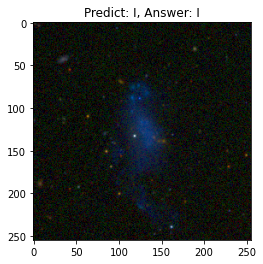

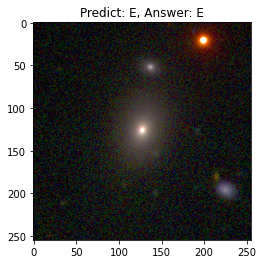

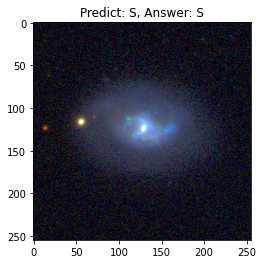

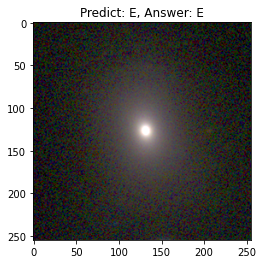

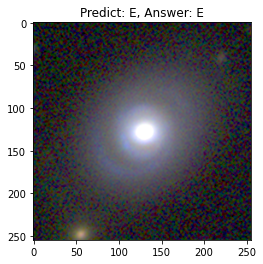

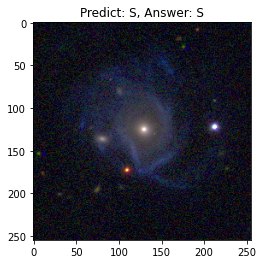

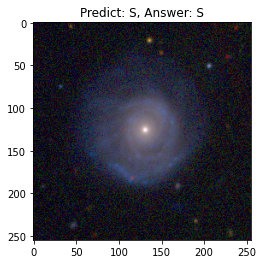

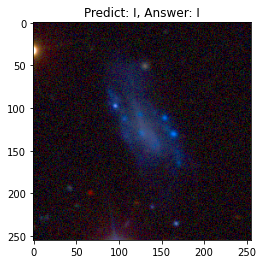

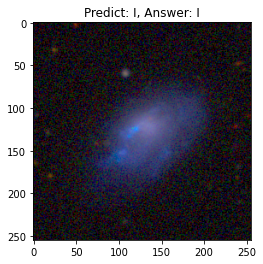

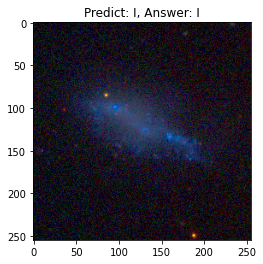

In [11]:
model = torch.load('E_I_S_new.pkl')
loss_func = nn.CrossEntropyLoss()
i = 0
for x, y in test_loader:
    i += 1
    if train_on_gpu:
        x, y = x.cuda(), y.cuda()
    output = model(x)
    out = output.argmax(dim = 1)
    out = out.to('cpu').numpy()
    if y[0] == 0:
        ans = 'E'
    elif y[0] == 1:
        ans = 'I'
    else:
        ans = 'S'
    if i % 10 == 0:
        plt.figure(i)
        if out[0] == 0:
            plt.title(f'Predict: E, Answer: {ans}')
        elif out[0] == 1:
            plt.title(f'Predict: I, Answer: {ans}')
        else:
            plt.title(f'Predict: S, Answer: {ans}')
        x = x.squeeze()
        x = x.to('cpu')
        plt.imshow(x.permute(1, 2, 0))
        plt.show()

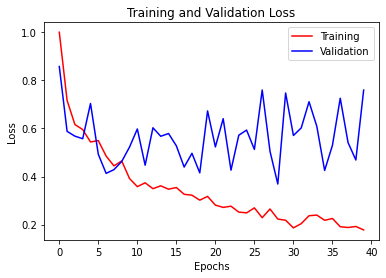

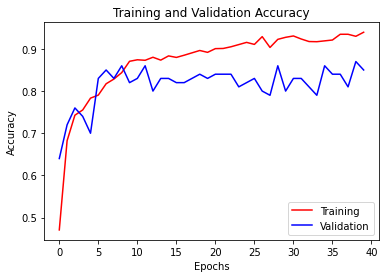

In [12]:
plt.figure(1)
plt.title('Training and Validation Loss')
train_l, = plt.plot(train_loss_record, color = 'red')
val_l, = plt.plot(val_loss_record, color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(handles = [train_l, val_l], labels = ['Training', 'Validation'], loc = 'best')
plt.show()

plt.figure(2)
plt.title('Training and Validation Accuracy')
train_a, = plt.plot(train_acc_record, color = 'red')
val_a, = plt.plot(val_acc_record, color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(handles = [train_a, val_a], labels = ['Training', 'Validation'], loc = 'best')
plt.show()

In [13]:
answer = pd.Series(actu, name='Actual')
pred = pd.Series(ai_pred, name='Predicted', dtype = 'int64')
df_confusion = pd.crosstab(answer, pred, rownames=['True'], colnames=['Predicted'], margins=True)

In [14]:
def plot_confusion_matrixs(df_confusion, title='Confusion matrix', cmap=plt.cm.hot):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
#     plt.xticks(tick_marks, df_confusion.columns, rotation=45)
#     plt.yticks(tick_marks, df_confusion.index)
    plt.xticks([0, 1, 2, 3],['E', 'I', 'S', 'All'])
    plt.yticks([0, 1, 2, 3],['E', 'I', 'S', 'All'])
    plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

/tmp/ipykernel_17133/249108228.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


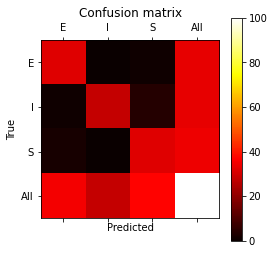

In [15]:
plot_confusion_matrixs(df_confusion)

In [16]:
confmat = confusion_matrix(y_true=actu, y_pred=ai_pred)

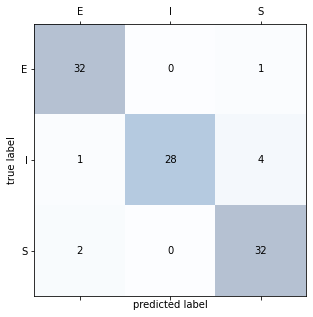

In [17]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i,j], va='center', ha='center')
plt.xlabel('predicted label')        
plt.ylabel('true label')
plt.xticks([0, 1, 2],['E', 'I', 'S'])
plt.yticks([0, 1, 2],['E', 'I', 'S'])
plt.show()